In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import dwong


In [2]:
dwong.os.chdir("/Users/wongdowling/Desktop/DQ_Dowling/electron/csv/")
data = pd.read_csv("Ep.csv")

In [3]:
#define the predictor variables and the response variable
X = data[["wew_x","wew_y", "wid_x", "wid_y", "diff_x","diff_y", "E/p"]]
y = data["label"]

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
#instantiate the model
log_regression = LogisticRegression()
#fit the model using the training data
log_regression.fit(X_train,y_train)
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
log_fpr, log_tpr, log_thres = metrics.roc_curve(y_test,  y_pred_proba)
log_auc = metrics.roc_auc_score(y_test, y_pred_proba)

/Users/wongdowling/opt/anaconda3/envs/dq/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
from sklearn.svm import SVC
#instantiate the model
model_SVC = SVC(kernel = 'rbf', random_state = 4)
#fit the model using the training data
model_SVC.fit(X_train, y_train)
y_pred_svm = model_SVC.decision_function(X_test)
svm_fpr, svm_tpr, svm_thres = roc_curve(y_test, y_pred_svm)
svm_auc = auc(svm_fpr, svm_tpr)

In [5]:
x=data[["wew_x","wew_y", "wid_x", "wid_y", "diff_x","diff_y", "E/p"]].values
y=data['label'].values

In [6]:
import torch
import io
import copy

try:
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Early stopping (see Module 3.4)
class EarlyStopping():
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
    
    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

# Make use of a GPU or MPS (Apple) if one is available. (see Module 3.2)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: mps


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time


# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).float().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],1).to(device)

loss_fn = nn.BCELoss()# Binary Cross Entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch.reshape(-1,1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1)* len(x_batch)
        if i == len(steps)-1:
            model.eval()
            pred = model(x_test)
            vloss = loss_fn(pred, y_test.reshape(-1,1))
            if es(model,vloss): done = True
            pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 0.04591839760541916, vloss: 1.271682, EStop:[0/15]: 100%|█| 375
Epoch: 2, tloss: 6.265486240386963, vloss: 1.291604, EStop:[1/15]: 100%|█| 375/3
Epoch: 3, tloss: 0.3208978772163391, vloss: 1.254182, EStop:[0/15]: 100%|█| 375/
Epoch: 4, tloss: 0.004058507736772299, vloss: 1.243703, EStop:[0/15]: 100%|█| 37
Epoch: 5, tloss: 6.256924629211426, vloss: 1.238934, EStop:[0/15]: 100%|█| 375/3
Epoch: 6, tloss: 6.2609052658081055, vloss: 1.235019, EStop:[0/15]: 100%|█| 375/
Epoch: 7, tloss: 6.255600929260254, vloss: 1.242430, EStop:[1/15]: 100%|█| 375/3
Epoch: 8, tloss: 0.0017933475319296122, vloss: 1.233570, EStop:[0/15]: 100%|█| 3
Epoch: 9, tloss: 6.266240119934082, vloss: 1.235349, EStop:[1/15]: 100%|█| 375/3
Epoch: 10, tloss: 0.02685166522860527, vloss: 1.252635, EStop:[2/15]: 100%|█| 37
Epoch: 11, tloss: 0.004300050437450409, vloss: 1.237818, EStop:[3/15]: 100%|█| 3
Epoch: 12, tloss: 0.008452502079308033, vloss: 1.232349, EStop:[0/15]: 100%|█| 3
Epoch: 13, tloss: 0.02860757

In [8]:
pred = model(x_test)
fpr, tpr, _ = roc_curve(y_test.cpu(), pred.cpu().detach())
roc_auc = auc(fpr, tpr)

In [9]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)


Epoch 1/1000
188/188 - 0s - loss: 0.3178 - accuracy: 0.9187 - val_loss: 0.2727 - val_accuracy: 0.9595 - 346ms/epoch - 2ms/step
Epoch 2/1000
188/188 - 0s - loss: 0.1452 - accuracy: 0.9615 - val_loss: 0.1231 - val_accuracy: 0.9700 - 125ms/epoch - 663us/step
Epoch 3/1000
188/188 - 0s - loss: 0.1200 - accuracy: 0.9662 - val_loss: 0.1098 - val_accuracy: 0.9705 - 123ms/epoch - 655us/step
Epoch 4/1000
188/188 - 0s - loss: 0.1090 - accuracy: 0.9715 - val_loss: 0.1029 - val_accuracy: 0.9740 - 122ms/epoch - 649us/step
Epoch 5/1000
188/188 - 0s - loss: 0.1070 - accuracy: 0.9727 - val_loss: 0.1034 - val_accuracy: 0.9740 - 126ms/epoch - 669us/step
Epoch 6/1000
188/188 - 0s - loss: 0.1017 - accuracy: 0.9752 - val_loss: 0.0981 - val_accuracy: 0.9760 - 125ms/epoch - 667us/step
Epoch 7/1000
188/188 - 0s - loss: 0.1006 - accuracy: 0.9750 - val_loss: 0.0970 - val_accuracy: 0.9785 - 128ms/epoch - 683us/step
Epoch 8/1000
188/188 - 0s - loss: 0.0982 - accuracy: 0.9757 - val_loss: 0.0963 - val_accuracy: 0.97

In [10]:
pred1 = model(x_test)
fpr1, tpr1, _ = roc_curve(y_test, pred1)
roc_auc1 = auc(fpr1, tpr1)

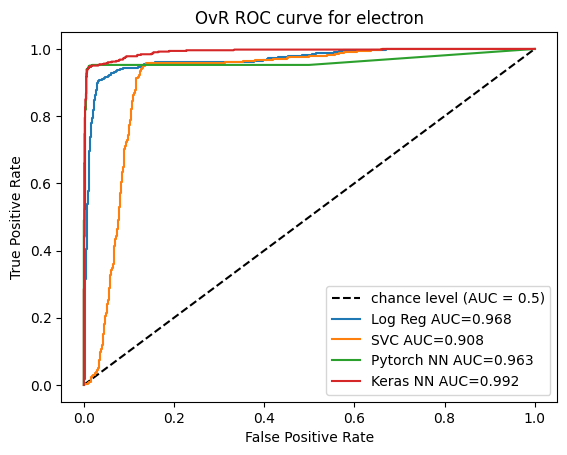

In [11]:
#create ROC curve
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")#diagonal line
plt.plot(log_fpr,log_tpr,label="Log Reg AUC="+str(round(log_auc,3)))
plt.plot(svm_fpr,svm_tpr,label="SVC AUC="+str(round(svm_auc,3)))
plt.plot(fpr,tpr,label="Pytorch NN AUC="+str(round(roc_auc,3)))
plt.plot(fpr1,tpr1,label="Keras NN AUC="+str(round(roc_auc1,3)))



plt.title("OvR ROC curve for electron")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("OvR_electron.png")
plt.show()